Init Plugin
Init Graph Optimizer
Init Kernel
shapes of the dataset:
(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


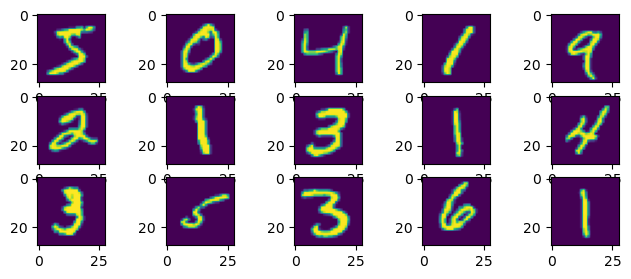

In [1]:
import numpy as np
# only for the dataset :)
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train/255, axis =1)
x_test = np.expand_dims(x_test/255, axis =1)

print('shapes of the dataset:')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


nrows, ncols = (3, 5)
fig, ax = plt.subplots(nrows, ncols, figsize=(8, 3))

filters =[x_train[i][0] for i in range(nrows * ncols)]

for i, data in enumerate(filters):
  ax[i // ncols, i % ncols].imshow(data)

In [7]:
# without batch size
def training_loop(model, loss_function, x_train, y_train, itterations):
    model.Train()
    assert x_train.shape[0]== y_train.shape[0], f'dataset and targets are not the same lenght'
    losses = []
    for i in range(itterations):
        idx = np.random.choice(x_train.shape[0], size=1)
        x = x_train[idx].squeeze(axis=0)
        y = y_train[idx]
    
        # forward
        x = model.forward(x)
        loss = loss_function.get_loss(x, y)
        losses.append(loss)
        
        # backward
        next_errors = loss_function.backward()
        _ = model.backward(next_errors)
        
        # plot losses
        display.clear_output(wait=True)
        plt.plot(losses, label='Loss (inc loss weights)')
        plt.xlabel('Itterations')
        plt.ylabel('Loss')
        plt.title('Training Loss at itteration %d' %(i+1))
        plt.legend()
        plt.show()   
    return losses    

In [8]:
# define model
import Layers
from Sequential import sequential
from optimizer_and_loss_function import Adam_optimizer, Categorical_cross_entropy_loss

mnist_model_1 = sequential([
                            Layers.Conv2d_max_Cin((1,28,28), 5, kernel=(5, 5), strides=(1,1)),
                            Layers.ReLu(), 
                            Layers.MAXpool((5, 24, 24), kernel=(2,2), strides=(2,2)),
                            Layers.Conv2d_max_Cin((5,12,12), 10, kernel=(3, 3), strides=(1,1)),
                            Layers.ReLu(), 
                            Layers.MAXpool((10, 10, 10), kernel=(2,2), strides=(2,2)),
                            Layers.Reshape((10,5,5),(250)),
                            Layers.Linear(250, 10),
                            Layers.Softmax(10)
                        ]) 
mnist_model_1.Train()
loss_function = Categorical_cross_entropy_loss(10)

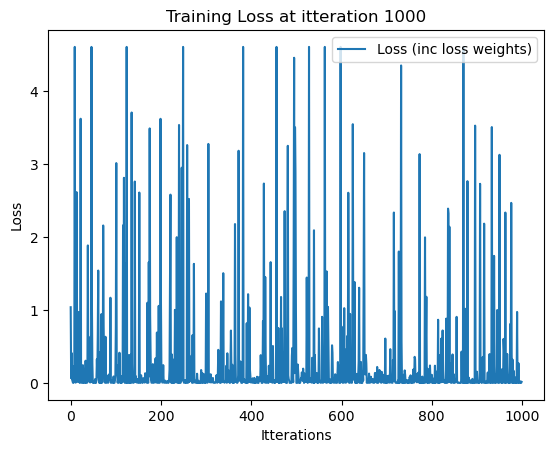

In [9]:
# Full training loop to achieve the 90% accuracy below:
optimizer = Adam_optimizer(LR=0.1, B_1=0.9 , B_2=0.999, weight_decay=0.001)
mnist_model_1.Optimizer(optimizer)
losses = training_loop(mnist_model_1, loss_function, x_train, y_train, 1000)

optimizer = Adam_optimizer(LR=0.01, B_1=0.9 , B_2=0.999, weight_decay=0.0001)
mnist_model_1.Optimizer(optimizer)
losses = training_loop(mnist_model_1, loss_function, x_train, y_train, 1000)

mnist_model_1.Save_model('mnist_model_1')

In [10]:
mnist_model_1.Load_model('mnist_model_1')
mnist_model_1.Eval()

incorrect = 0
for i in tqdm(range(5000)):
    x = x_test[[i]].squeeze(axis=0)
    y = y_test[i]
    out = mnist_model_1.forward(x)
    out = out.argmax()
    if out != y:
        incorrect+=1
        
accuracy = ((5000-incorrect)/5000)*100
print(f'out of sample accuracy: {accuracy}%')

100%|██████████| 5000/5000 [00:29<00:00, 171.17it/s]

out of sample accuracy: 89.16%


Now with normal convolutional layer

In [46]:
mnist_model_2 = sequential([
                            Layers.Conv2d((1,28,28), 10, kernel=(5, 5), strides=(1,1)),
                            Layers.ReLu(), 
                            Layers.MAXpool((10, 24, 24), kernel=(2,2), strides=(2,2)),
                            Layers.Conv2d((10,12,12), 12, kernel=(3, 3), strides=(1,1)),
                            Layers.ReLu(), 
                            Layers.MAXpool((12, 10, 10), kernel=(2,2), strides=(2,2)),
                            Layers.Reshape((12,5,5),(300)),
                            Layers.Linear(300, 10),
                            Layers.Softmax(10)
                        ]) 
mnist_model_2.Train()
loss_function = Categorical_cross_entropy_loss(10)

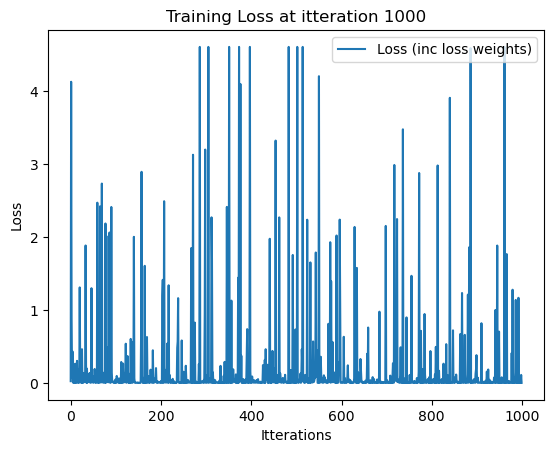

100%|██████████| 1000/1000 [01:11<00:00, 13.89it/s]


In [47]:
optimizer = Adam_optimizer(LR=0.1, B_1=0.9 , B_2=0.999, weight_decay=0.001)
mnist_model_2.Optimizer(optimizer)
losses = training_loop(mnist_model_2, loss_function, x_train, y_train, 1000)

optimizer = Adam_optimizer(LR=0.01, B_1=0.9 , B_2=0.999, weight_decay=0.0001)
mnist_model_2.Optimizer(optimizer)
losses = training_loop(mnist_model_2, loss_function, x_train, y_train, 1000)

mnist_model_2.Save_model('mnist_model_2')

In [48]:
mnist_model_2.Load_model('mnist_model_2')
mnist_model_2.Eval()

incorrect = 0
for i in tqdm(range(5000)):
    x = x_test[[i]].squeeze(axis=0)
    y = y_test[i]
    out = mnist_model_2.forward(x)
    out = out.argmax()
    if out != y:
        incorrect+=1
        
accuracy = ((5000-incorrect)/5000)*100
print(f'out of sample accuracy: {accuracy}%')

100%|██████████| 5000/5000 [00:37<00:00, 132.02it/s]

out of sample accuracy: 91.94%


Now with batch size:

In [17]:
# training loop with batch size 
def batch_training_loop(model, loss_function, x_train, y_train, itterations, batch_size=10):
    model.Train()
    assert x_train.shape[0]== y_train.shape[0], f'dataset and targets are not the same lenght'
    
    losses = []
    for i in range(itterations):
        
        batch_idxs = np.random.choice(x_train.shape[0], size=batch_size)
        x_batch = x_train[batch_idxs] 
        y_batch = y_train[batch_idxs]
        # forward
        x_batch = model.forward(x_batch)
        loss = loss_function.get_loss(x_batch, y_batch)
        losses.append(loss)
        
        # backward
        next_errors = loss_function.backward()
        _ = model.backward(next_errors)
        
        # plot losses
        display.clear_output(wait=True)
        plt.plot(losses, label='Loss (inc loss weights)')
        plt.xlabel('Itterations')
        plt.ylabel('Loss')
        plt.title('Training Loss at itteration %d' %(i+1))
        plt.legend()
        plt.show()
    return losses

In [18]:
import Layers_with_batch
from Sequential import sequential
from optimizer_and_loss_function import Adam_optimizer, Categorical_cross_entropy_loss

mnist_model_3 = sequential([
                            Layers_with_batch.Conv2d((1,28,28), 10, kernel=(5, 5), strides=(1,1)),
                            Layers_with_batch.Batch_norm((10,24,24)),
                            Layers_with_batch.ReLu(), 
                            Layers_with_batch.MAXpool((10, 24, 24), kernel=(2,2), strides=(2,2)),
                            Layers_with_batch.Conv2d((10,12,12), 12, kernel=(3, 3), strides=(1,1)),
                            Layers_with_batch.Batch_norm((12,10,10)),
                            Layers_with_batch.ReLu(), 
                            Layers_with_batch.MAXpool((12, 10, 10), kernel=(2,2), strides=(2,2)),
                            Layers_with_batch.Reshape((12,5,5),(300,)),
                            Layers_with_batch.Linear(300, 10),
                            Layers_with_batch.Softmax(10)
                        ]) 
mnist_model_3.Train()
loss_function = Categorical_cross_entropy_loss(10)

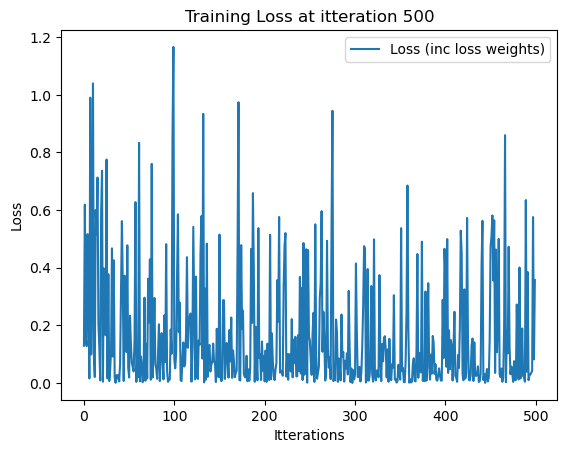

In [19]:
optimizer = Adam_optimizer(LR=0.1, B_1=0.9 , B_2=0.999, weight_decay=0.001)
mnist_model_3.Optimizer(optimizer)
losses = batch_training_loop(mnist_model_3, loss_function, x_train, y_train, 500, 10)


optimizer = Adam_optimizer(LR=0.01, B_1=0.9 , B_2=0.999, weight_decay=0.0001)
mnist_model_3.Optimizer(optimizer)
losses = batch_training_loop(mnist_model_3, loss_function, x_train, y_train, 500, 10)

mnist_model_3.Save_model('mnist_model_3')

In [21]:
mnist_model_3.Load_model('mnist_model_3')
mnist_model_3.Eval()

incorrect = 0
for i in range(500):
    x = x_test[np.arange(i*10, (i*10)+10)]
    y = y_test[np.arange(i*10, (i*10)+10)]
    out = mnist_model_3.forward(x)
    out = out.argmax(axis=-1)
    incorrect += (out!=y).sum()
        
accuracy = ((5000-incorrect)/5000)*100
print(f'out of sample accuracy: {accuracy}%')

out of sample accuracy: 93.22%
